In [482]:
import json
from urllib.parse import urlencode
from urllib.request import urlretrieve
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from string import ascii_letters

import requests
from lxml import html
import re
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.covariance import empirical_covariance

from mpl_toolkits import mplot3d

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

idx = pd.IndexSlice

In [2]:
def get_nba_data(endpt, params, return_url=False):

    ## endpt: https://github.com/seemethere/nba_py/wiki/stats.nba.com-Endpoint-Documentation
    ## params: dictionary of parameters: i.e., {'LeagueID':'00'}

    useragent = "\"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/601.3.9 (KHTML, like Gecko) Version/9.0.2 Safari/601.3.9\""
    dataurl = "\"" + "http://stats.nba.com/stats/" + endpt + "?" + urlencode(params) + "\""
    
    # for debugging: just return the url
    if return_url:
        return(dataurl)
    
    jsonstr = !wget -q -O - --user-agent={useragent} {dataurl}
    
    data = json.loads(jsonstr[0])
    
    h = data['resultSets'][0]['headers']
    d = data['resultSets'][0]['rowSet']
    
    return(pd.DataFrame(d, columns=h))

def get_params(url):
    endpt = url.split('stats/')[1].split('?')[0]
    params = {}
    paramstring = url.split('stats/')[1].split('?')[1]

    for substring in paramstring.split("&"):
        variable = substring.split('=')[0]
        value = substring.split('=')[1]
        params.update({variable:value})
    return([endpt,params])
user_agent = "\"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/601.3.9 (KHTML, like Gecko) Version/9.0.2 Safari/601.3.9\""

headers = {'User-Agent':user_agent}

def SportsRefCBBRowMaker(player_url,table_list,player_name,correct_year,player_id="0"):
    
    page = requests.get(player_url,headers=headers)
    tree = html.fromstring(page.content)
    
    if '404' in tree.xpath('//title')[0].text:
        return('404')
    else:
        year = tree.xpath('//table/tbody/tr')[-1].items()[0][-1][-4:]
        if(year!=correct_year):
            return(year)
        
        for i,table_name in enumerate(table_list):
            path = '//div[@id="'+table_name+'"]'
            try:
                treeStr = str(tree.xpath(path)[0].getchildren()[-1])[8:-4]
            except:
                continue
            #This is tricky and comments might be nice here. 

            tree2 = html.fromstring(treeStr)

            valuesHTML = tree2.xpath('//table/tfoot/tr')[-1].getchildren()[1:]
            ## This gives career in particular 
            conf = tree2.xpath('//table/tbody/tr/td')[1].getchildren()[0].text
            colNamesHTML = tree2.xpath('//table/thead/tr/th')
            colNames = ["PLAYER_ID","PLAYER_NAME"]+["CONF"] + [col.text for col in colNamesHTML][1:]
            values = [player_id,player_name] + [conf] + [val.text for val in valuesHTML]
            if(i==0):
                row = pd.DataFrame(pd.Series(values,index=colNames)\
                    .dropna()).transpose()
            else:
                row = pd.merge(row,pd.DataFrame(pd.Series(values,index=colNames)\
                    .dropna()).transpose())
        return(row)
    
def sportsRefCBBTableMaker(player_df, table_list):
    base_url = 'https://www.sports-reference.com/cbb/players/'
    columns_df_url = "https://www.sports-reference.com/cbb/players/malcolm-brogdon-1.html"
    columns_df = SportsRefCBBRowMaker(columns_df_url,table_list
                                      ,"Malcolm Brogdon(2016)",'2016')
    CBB_df = pd.DataFrame(columns=columns_df.columns)
    for index,row in player_df.iterrows():
        player_name = row['PLAYER_NAME']
        first = re.sub('[^a-zA-Z]+', '',player_name.split()[0].lower())
        last = "".join(player_name.split()[1:])[0:-6].lower().strip(".")
        year = player_name.split()[1][-5:-1]
        name_url = base_url + first + "-" + last + "-"

        i = 1
        stopping_condition=False
        while(stopping_condition==False):
            data_url = name_url + str(i) + ".html"
#            print(data_url)
            row = SportsRefCBBRowMaker(data_url,table_list,player_name,year,player_id=index)
            if isinstance(row, pd.DataFrame):
                stopping_condition=True
                continue
            if(row=='404'):
                stopping_condition=True
                row = None
                if(last[-2:]=="jr"):
                    last = last[:-2]
                    name_url = base_url + first + "-" + last + "-"
                    i=1
                    stopping_condition = False 
            i+=1
        CBB_df = pd.concat([CBB_df,row])
    return(CBB_df)

In [3]:
main_df = pickle.load(open('NBA_2014_18_Adv_100_Score_Def.pkl','rb'))
Player_ID_Dict = pickle.load(open('NBAPlayerDict.pkl','rb'))

In [8]:
main_df_reg_season = main_df.loc[idx[:,:,'Regular Season'],:]

In [27]:
main_df_reg_season.head(10)
qualified_df = main_df_reg_season.query('SEASON_MIN>800')
qualified_df.head(10)

PLAYER_NAME   AGE  AST_PCT  AST_RATIO  \
PLAYER_ID SEASON SEASON_TYPE                                                 
101106    2014   Regular Season     Andrew Bogut  29.0    0.087       18.3   
          2015   Regular Season     Andrew Bogut  30.0    0.149       27.3   
          2016   Regular Season     Andrew Bogut  31.0    0.145       29.7   
101107    2014   Regular Season  Marvin Williams  28.0    0.075       11.3   
          2015   Regular Season  Marvin Williams  29.0    0.078       14.4   
          2016   Regular Season  Marvin Williams  30.0    0.074       11.2   
          2017   Regular Season  Marvin Williams  31.0    0.072       11.3   
          2018   Regular Season  Marvin Williams  31.0    0.069       12.3   
101108    2014   Regular Season       Chris Paul  29.0    0.459       36.2   
          2015   Regular Season       Chris Paul  30.0    0.441       35.8   

                                 AST_TO  DEF_RATING  DREB_PCT  EFG_PCT  GP  \
PLAYER_ID SEASON SEASON_TYPE                                                 
101106    2014   Regular Season    1.15        98.8     0.293    0.627  67   
          2015   Regular Season    1.70        95.2     0.262    0.563  67   
          2016   Regular Season    1.95        97.2     0.252    0.629  70   
101107    2014   Regular Season    1.47       110.4     0.179    0.519  66   
          2015   Regular Season    1.67       102.2     0.183    0.520  78   
          2016   Regular Season    1.77       102.6     0.187    0.554  81   
          2017   Regular Season    1.77       106.4     0.202    0.510  76   
          2018   Regular Season    1.45       105.5     0.155    0.570  78   
101108    2014   Regular Season    4.57       100.1     0.114    0.511  62   
          2015   Regular Season    4.41       102.9     0.124    0.545  82   

                                  MIN     ...      DEF_FREQ_3Pt  \
PLAYER_ID SEASON SEASON_TYPE              ...                     
101106    2014   Regular Season  26.4     ...             0.064   
          2015   Regular Season  23.6     ...             0.065   
          2016   Regular Season  20.7     ...             0.082   
101107    2014   Regular Season  25.4     ...             0.263   
          2015   Regular Season  26.1     ...             0.245   
          2016   Regular Season  28.9     ...             0.293   
          2017   Regular Season  30.2     ...             0.362   
          2018   Regular Season  25.7     ...             0.331   
101108    2014   Regular Season  35.0     ...             0.352   
          2015   Regular Season  34.8     ...             0.414   

                                 DEF_FREQ_Gt15  DEF_FREQ_Lt10  DEF_FREQ_Lt6  \
PLAYER_ID SEASON SEASON_TYPE                                                  
101106    2014   Regular Season          0.267          0.628         0.483   
          2015   Regular Season          0.258          0.672         0.489   
          2016   Regular Season          0.265          0.635         0.491   
101107    2014   Regular Season          0.435          0.478         0.342   
          2015   Regular Season          0.460          0.457         0.332   
          2016   Regular Season          0.472          0.463         0.379   
          2017   Regular Season          0.526          0.403         0.314   
          2018   Regular Season          0.501          0.423         0.336   
101108    2014   Regular Season          0.558          0.338         0.249   
          2015   Regular Season          0.646          0.267         0.177   

                                DEF_PCT_PLUSMINUS_2Pt DEF_PCT_PLUSMINUS_3Pt  \
PLAYER_ID SEASON SEASON_TYPE                                                  
101106    2014   Regular Season                -0.052                -0.056   
          2015   Regular Season                -0.075                -0.008   
          2016   Regular Season                -0.051                -0.005   
101107    2014

In [401]:
advancedVars = ['AST_PCT','AST_RATIO','AST_TO','DEF_RATING','DREB_PCT',
                'EFG_PCT','OFF_RATING','OREB_PCT','PACE','REB_PCT',
                'TM_TOV_PCT','TS_PCT','USG_PCT']

per100pVars_shots = ['FG3A','FG3M','FG3_PCT','FGA','FGM','FG_PCT',
                     'FTA','FTM','FT_PCT'
                    ]
per100pVars_basic = ['AST','BLK','DREB','OREB','STL','PTS','PF','TOV']
per100pVars_other= ['BLKA','PFD','PLUS_MINUS']

scoringVars = list(qualified_df.columns[40:55])
defensiveVars = list(qualified_df.columns[55:65])
all_cols = advancedVars+per100pVars_shots+scoringVars+defensiveVars+per100pVars_basic+per100pVars_other

In [402]:
X = qualified_df[all_cols]
X_scaled = scale(X)
pca = PCA(n_components=10)
pca.fit(X)
PCA_df = pd.DataFrame(pca.components_,columns=all_cols)
PCA_df.index.name = "Principle Component"
X_scaled = pd.DataFrame(X_scaled,columns=all_cols)
X_scaled.head()

,AST_PCT,AST_RATIO,AST_TO,DEF_RATING,DREB_PCT,EFG_PCT,OFF_RATING,OREB_PCT,PACE,REB_PCT,...,BLK,DREB,OREB,STL,PTS,PF,TOV,BLKA,PFD,PLUS_MINUS
0,-0.621360,0.243957,-0.640586,-1.558337,2.322227,2.430338,0.758892,1.830497,0.271969,2.319296,...,2.650276,2.512790,1.716331,-0.445153,-1.189293,1.301491,-0.041879,-1.279877,-0.753302,1.502564
1,0.057155,1.424758,0.140347,-2.531586,1.811484,1.106864,1.672951,1.401424,0.667213,1.823461,...,2.764734,2.069210,1.294800,-0.617928,-1.309703,1.221561,0.470836,-0.823163,-0.984131,2.860131
2,0.013380,1.739639,0.495317,-1.990892,1.646728,2.471696,1.602639,1.213705,1.230249,1.672554,...,3.222567,2.032246,1.114144,-0.790703,-1.412912,2.500432,-0.041879,-1.736590,-0.926423,2.285776
3,-0.752686,-0.674445,-0.186225,1.577686,0.444008,0.196976,0.032332,0.167840,-1.748996,0.314397,...,0.017736,0.405789,0.210864,0.245946,-0.329222,0.342337,-1.169851,-1.051520,-1.041838,-0.934094
4,-0.719854,-0.267724,0.097751,-0.639158,0.509911,0.217655,-1.561412,-0.475769,-0.712413,0.098816,...,-0.096722,0.516684,-0.451541,0.245946,-1.086085,-0.456957,-1.272394,-1.508233,-1.157252,-0.673024


In [403]:
PCA_df=PCA_df.append(pd.DataFrame(pca.mean_,index=all_cols,columns=['means']).transpose())
PCA_df

,AST_PCT,AST_RATIO,AST_TO,DEF_RATING,DREB_PCT,EFG_PCT,OFF_RATING,OREB_PCT,PACE,REB_PCT,...,BLK,DREB,OREB,STL,PTS,PF,TOV,BLKA,PFD,PLUS_MINUS
0,0.004531,0.738966,0.053792,-0.043597,-0.002584,-0.001238,-0.054720,-0.001348,-0.015674,-0.001969,...,-0.026759,-0.113285,-0.059155,0.019972,-0.469046,0.000106,0.005289,-0.017230,-0.089357,-0.032189
1,0.008244,0.478313,0.047667,-0.091501,-0.001561,0.000283,0.314802,-0.001657,0.038533,-0.001537,...,-0.028754,-0.065647,-0.077527,0.021966,0.459344,-0.063604,0.063458,0.005809,0.089096,0.424760
2,0.005876,0.245372,0.017487,0.362712,-0.001748,-0.003081,-0.352501,-0.001531,0.041274,-0.001757,...,-0.037662,-0.093421,-0.063431,0.001617,0.262137,-0.035325,0.062087,0.020030,0.049343,-0.680594
3,0.003278,0.141979,-0.029279,-0.200789,0.008024,-0.000052,-0.169393,0.005224,-0.126198,0.006659,...,0.097691,0.363967,0.231349,0.010297,0.096844,0.105530,0.103253,0.041010,0.210626,0.005740
4,0.001121,-0.029665,0.006266,-0.648938,-0.003950,-0.004335,-0.582376,-0.002782,-0.327168,-0.003381,...,-0.033537,-0.155451,-0.116367,0.010458,0.034455,-0.018318,0.003938,-0.006756,-0.039208,0.063345
5,0.001261,-0.055212,-0.059806,-0.226182,0.001355,0.000567,-0.187123,-0.000527,0.788715,0.000500,...,0.016262,0.066327,-0.027514,0.026861,0.007063,0.069298,0.107828,0.010886,0.065575,0.024267
6,0.000017,0.088206,0.057199,-0.122103,0.003781,-0.000496,-0.100594,0.001729,0.438457,0.002729,...,0.026918,0.173212,0.080467,-0.013434,-0.014032,-0.063037,-0.089322,-0.002388,-0.254827,0.013933
7,-0.001018,-0.028016,0.053571,-0.111502,-0.011936,-0.002977,-0.046311,-0.002551,0.237583,-0.007248,...,-0.060534,-0.529809,-0.113004,0.027321,-0.015203,-0.157464,-0.111746,0.029453,0.200168,-0.008892
8,-0.000766,0.128148,0.085057,-0.024763,0.014207,0.001632,-0.118470,0.001566,0.002566,0.007831,...,0.039221,0.629231,0.077936,-0.008265,-0.000535,-0.086585,-0.144340,-0.041545,0.177026,-0.041404
9,0.000971,0.033360,0.040587,0.007029,-0.002833,-0.006156,0.009306,0.005769,0.027008,0.001147,...,0.122416,-0.173600,0.264802,0.052513,-0.072910,0.873241,-0.037755,0.025312,0.181416,0.001117


Lets pick two variables with a strong correlation for plotting purposes

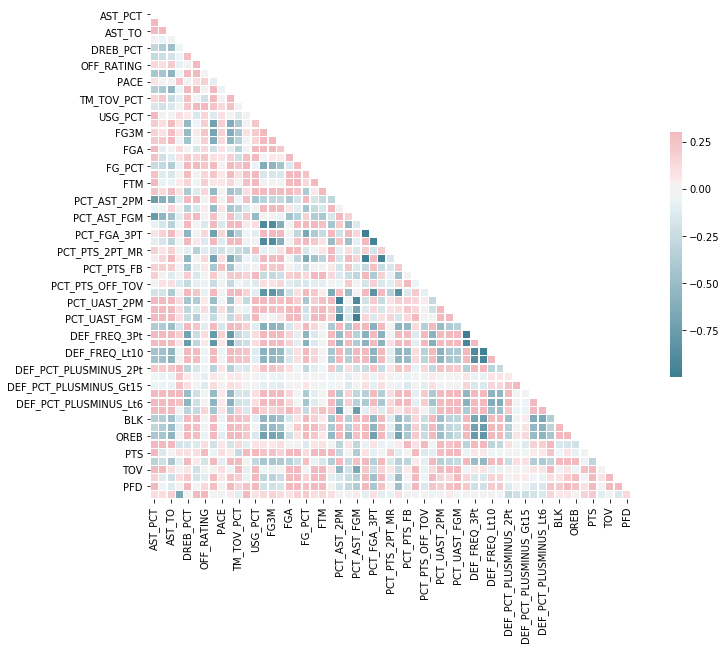

In [404]:
corr = X.corr()
f, ax = plt.subplots(figsize=(11, 9))

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [405]:
abs(corr.DEF_FREQ_3Pt).sort_values(ascending=False).head(20)

DEF_FREQ_3Pt             1.000000
DEF_FREQ_2Pt             1.000000
DEF_FREQ_Gt15            0.939498
DEF_FREQ_Lt10            0.911438
DEF_FREQ_Lt6             0.860722
REB_PCT                  0.774830
OREB_PCT                 0.774398
OREB                     0.772887
DREB                     0.715919
DREB_PCT                 0.706071
BLK                      0.678445
FG3A                     0.601798
PCT_FGA_3PT              0.590262
PCT_FGA_2PT              0.590261
DEF_PCT_PLUSMINUS_Lt6    0.580634
PCT_PTS_2PT              0.580510
PCT_PTS_PAINT            0.572241
FG3M                     0.570213
PCT_PTS_3PT              0.562205
FG_PCT                   0.554047
Name: DEF_FREQ_3Pt, dtype: float64

Lets look at OREB_PCT and DEF_FREQ_Lt10, both should indicate a big man but lets see if our principle components distingush the offensive and defensive implications

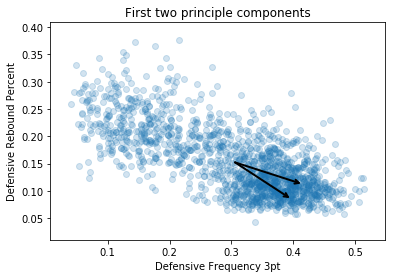

In [406]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)
    
plt.scatter(X.DEF_FREQ_3Pt,X.DREB_PCT,alpha=0.2)

components = np.array(PCA_df[['DEF_FREQ_3Pt','DREB_PCT']])

for length, vector in zip(pca.explained_variance_[0:2], components[0:2,:]):
    v = vector * 3 * np.sqrt(length)
    draw_vector(components[-1,:], components[-1,:] + v)
plt.xlabel('Defensive Frequency 3pt')
plt.ylabel('Defensive Rebound Percent')
plt.title('First two principle components');

In [407]:
pca = PCA(n_components=10)
pca.fit(X)
df = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_),columns=['Cumulative Variance Explained'])
df.index_name="N principle Components"
df

,Cumulative Variance Explained
0,0.295597
1,0.580516
2,0.761773
3,0.851582
4,0.908222
5,0.935307
6,0.954268
7,0.970503
8,0.982692
9,0.986680


In [408]:
pca.fit(X_scaled)
df = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_),columns=['Cumulative Variance Explained'])
df.index_name="N principle Components"
df

,Cumulative Variance Explained
0,0.324704
1,0.493098
2,0.582385
3,0.640235
4,0.683471
5,0.724361
6,0.760743
7,0.786140
8,0.810875
9,0.833474


More variance explained at every compontent pass 1 for non-scaled data. We will continue using that.
Also non-scaled data gets to 90% explained in just 4 and ~99% after 10

In [413]:
pca.fit(X)
X_pca = pca.transform(X)
pd.DataFrame(X_pca,index=X.index).head()

0          1          2         3  \
PLAYER_ID SEASON SEASON_TYPE                                                 
101106    2014   Regular Season   6.753412  -2.359579 -14.358495  7.485747   
          2015   Regular Season  14.085627   7.304580 -19.667870  8.187585   
          2016   Regular Season  16.555804   5.950867 -16.649165  7.732555   
101107    2014   Regular Season  -2.751747  -7.402482   2.737399 -5.053269   
          2015   Regular Season   4.057759 -10.215870  -0.427252 -2.214659   

                                        4         5         6         7  \
PLAYER_ID SEASON SEASON_TYPE                                              
101106    2014   Regular Season -1.998590  2.405926  2.299649 -4.556805   
          2015   Regular Season -1.675396  3.054901  3.629221 -4.179990   
          2016   Regular Season -3.860040  3.512869  3.885025 -3.310212   
101107    2014   Regular Season -2.039794 -5.731181 -1.301094 -3.240904   
          2015   Regular Season  5.332227 -0.050420  0.534919 -0.540889   

                                        8         9  
PLAYER_ID SEASON SEASON_TYPE                         
101106    2014   Regular Season  0.064703 -0.721372  
          2015   Regular Season -0.700743 -0.344546  
          2016   Regular Season  0.578221  1.248759  
101107    2014   Regular Season  1.657222  0.556550  
          2015   Regular Season  3.515554 -0.992008

Text(0,0.5,'component 2')

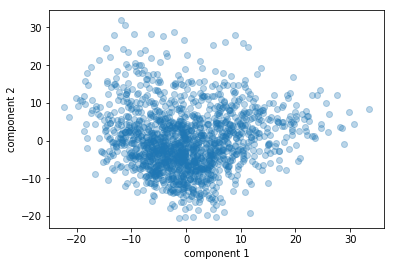

In [412]:
plt.scatter(X_pca[:,0],X_pca[:,1],alpha=0.3)
plt.xlabel('component 1')
plt.ylabel('component 2')

Not the most seperated. Consider using fewer columns

In [415]:
fewer_cols = advancedVars+scoringVars+defensiveVars+per100pVars_other
X = qualified_df[fewer_cols]
X_scaled = scale(X)
pca = PCA(n_components=10)
pca.fit(X)
PCA_df = pd.DataFrame(pca.components_,columns=fewer_cols)
PCA_df.index.name = "Principle Component"
X_scaled = pd.DataFrame(X_scaled,columns=fewer_cols)
#X_scaled.head()
pca.explained_variance_ratio_
df = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_),columns=['Cumulative Variance Explained'])
df.index_name="N principle Components"
df

,Cumulative Variance Explained
0,0.440691
1,0.777192
2,0.889504
3,0.936123
4,0.974825
5,0.994022
6,0.996316
7,0.997553
8,0.998441
9,0.998992


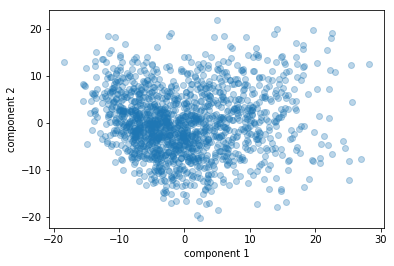

In [416]:
X_pca = pca.transform(X)
plt.scatter(X_pca[:,0],X_pca[:,1],alpha=0.3)
plt.xlabel('component 1')
plt.ylabel('component 2');

Looks a little better but we'll move on from here. Begin clustering with 4 dimensions using the full data

In [423]:
X = qualified_df[all_cols]
pca = PCA(n_components=4)
pca.fit(X)
X_pca = pca.transform(X)
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_pca)
y_kmeans = kmeans.predict(X_pca)


array([0, 3, 3, ..., 1, 2, 0], dtype=int32)

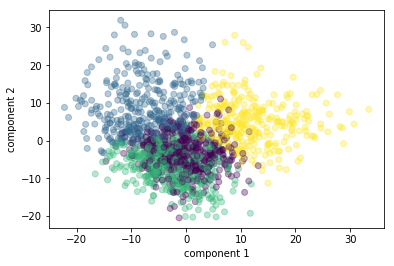

In [434]:
plt.scatter(X_pca[:,0],X_pca[:,1],alpha=0.35,c=y_kmeans,cmap='viridis')
plt.xlabel('component 1')
plt.ylabel('component 2');
plt.legend()

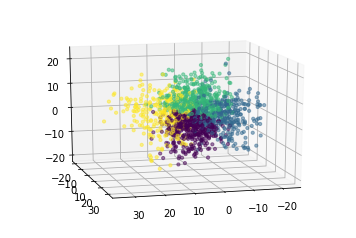

In [460]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')

ax.scatter3D(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],c=y_kmeans,alpha=.5,s=10)
ax.view_init(azim=75, elev=15)

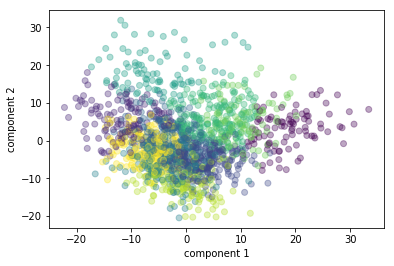

In [503]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(X_pca)
y_kmeans = kmeans.predict(X_pca)
plt.scatter(X_pca[:,0],X_pca[:,1],alpha=0.35,c=y_kmeans,cmap='viridis')
plt.xlabel('component 1')
plt.ylabel('component 2');
#plt.legend()

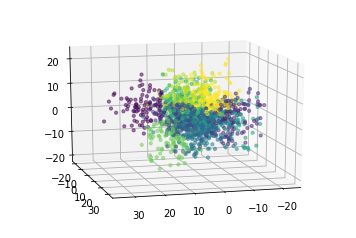

In [504]:
ax = plt.axes(projection='3d')

ax.scatter3D(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],c=y_kmeans,alpha=.5,s=10)
ax.view_init(azim=75, elev=15)

Not as nice seperation as our friend. Lets try with the reduced feature numbers. 

   Cumulative Variance Explained
0                       0.899871
1                       0.983293


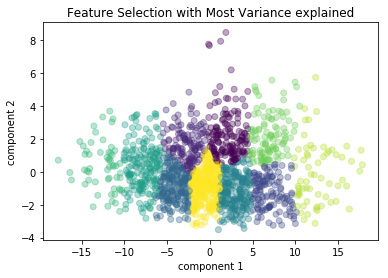

In [558]:
fewer_cols = scoringVars+defensiveVars+per100pVars_other
X = qualified_df[fewer_cols]
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)
df = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_),columns=['Cumulative Variance Explained'])
df.index_name="N principle Components"
print(df)
kmeans = KMeans(n_clusters=10)
kmeans.fit(X_pca)
y_kmeans = kmeans.predict(X_pca)
plt.scatter(X_pca[:,0],X_pca[:,1],alpha=0.35,c=y_kmeans,cmap='viridis')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('Feature Selection with Most Variance explained');

This seems to be our best seperation among 2 compontents

Next consider a less agressive but still good seperator

   Cumulative Variance Explained
0                       0.440691
1                       0.777192
2                       0.889504
3                       0.936123
4                       0.974825


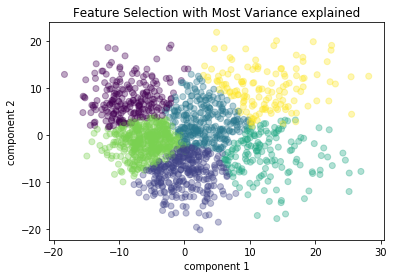

In [721]:
fewer_cols = scoringVars+defensiveVars+per100pVars_other+advancedVars
X = qualified_df[fewer_cols]
pca = PCA(n_components=5)
pca.fit(X)
X_pca = pca.transform(X)
df = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_),columns=['Cumulative Variance Explained'])
df.index_name="N principle Components"
print(df)
kmeans = KMeans(n_clusters=6)
kmeans.fit(X_pca)
y_kmeans = kmeans.predict(X_pca)
plt.scatter(X_pca[:,0],X_pca[:,1],alpha=0.35,c=y_kmeans,cmap='viridis')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('Feature Selection with Most Variance explained');

This works really well for 6

We aim to have somewhere from 6-9 Principle Components. Lets take some looks at sillhouette score. 



In [722]:
fewer_cols = scoringVars+defensiveVars+per100pVars_other+advancedVars
X = qualified_df[fewer_cols]
pca = PCA(n_components=5)
pca.fit(X)
X_pca = pca.transform(X)

range_n_clusters = [5,6,7,8,9,10]

x = pd.DataFrame(columns=range_n_clusters,index=range(0,max(range_n_clusters)))
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters)
    y_kmeans = kmeans.fit_predict(X)
    silhouette_score_mean = silhouette_score(X,y_kmeans)
    
    x[n_clusters]=pd.Series(y_kmeans).value_counts().sort_index()
    print("Average silhouette with {0:2} clusters = {1:3}".format(n_clusters,silhouette_score_mean))
x

Average silhouette with  5 clusters = 0.1899731221577863
Average silhouette with  6 clusters = 0.19203516590382494
Average silhouette with  7 clusters = 0.18664149887187176
Average silhouette with  8 clusters = 0.18396948899251944
Average silhouette with  9 clusters = 0.17519159048812663
Average silhouette with 10 clusters = 0.1706867682491057


,5,6,7,8,9,10
0,250.0,220.0,181.0,229.0,212.0,120
1,225.0,136.0,248.0,312.0,203.0,212
2,224.0,322.0,347.0,221.0,66.0,137
3,535.0,268.0,234.0,150.0,133.0,127
4,289.0,154.0,188.0,101.0,198.0,157
5,NaN,423.0,101.0,92.0,91.0,74
6,NaN,NaN,224.0,194.0,173.0,259
7,NaN,NaN,NaN,224.0,208.0,166
8,NaN,NaN,NaN,NaN,239.0,80
9,NaN,NaN,NaN,NaN,NaN,191


In [723]:
#fewer_cols = scoringVars+defensiveVars+per100pVars_other+advancedVars
X = qualified_df[all_cols]
pca = PCA(n_components=5)
pca.fit(X)
X_pca = pca.transform(X)

range_n_clusters = [5,6,7,8,9,10]

x = pd.DataFrame(columns=range_n_clusters,index=range(0,max(range_n_clusters)))
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters)
    y_kmeans = kmeans.fit_predict(X)
    silhouette_score_mean = silhouette_score(X,y_kmeans)
    
    x[n_clusters]=pd.Series(y_kmeans).value_counts().sort_index()
    print("Average silhouette with {0:2} clusters = {1:3}".format(n_clusters,silhouette_score_mean) )
x

Average silhouette with  5 clusters = 0.16288860608890962
Average silhouette with  6 clusters = 0.1594764525810289
Average silhouette with  7 clusters = 0.1527842239507381
Average silhouette with  8 clusters = 0.1532952610295085
Average silhouette with  9 clusters = 0.15500267554666067
Average silhouette with 10 clusters = 0.15222284111449272


,5,6,7,8,9,10
0,407.0,278.0,221.0,212.0,115.0,144
1,340.0,287.0,243.0,142.0,222.0,172
2,288.0,174.0,217.0,150.0,257.0,111
3,155.0,333.0,138.0,197.0,109.0,163
4,333.0,213.0,255.0,109.0,96.0,178
5,NaN,238.0,172.0,263.0,198.0,234
6,NaN,NaN,277.0,191.0,178.0,109
7,NaN,NaN,NaN,259.0,192.0,131
8,NaN,NaN,NaN,NaN,156.0,192
9,NaN,NaN,NaN,NaN,NaN,89


In [724]:
fewer_cols = scoringVars+defensiveVars+per100pVars_other
X = qualified_df[fewer_cols]
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

range_n_clusters = [3,4,5,6,7,8,9,10]


x = pd.DataFrame(columns=range_n_clusters,index=range(0,max(range_n_clusters)))

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters)
    y_kmeans = kmeans.fit_predict(X)
    silhouette_score_mean = silhouette_score(X,y_kmeans)
    
    x[n_clusters]=pd.Series(y_kmeans).value_counts().sort_index()
    print("Average silhouette with {0:2} clusters = {1:3}".format(n_clusters,silhouette_score_mean) )
x

Average silhouette with  3 clusters = 0.4092933342569296
Average silhouette with  4 clusters = 0.36040594079684235
Average silhouette with  5 clusters = 0.3270949132459015
Average silhouette with  6 clusters = 0.3240999139057392
Average silhouette with  7 clusters = 0.3152398244216414
Average silhouette with  8 clusters = 0.303059680631671
Average silhouette with  9 clusters = 0.2955633075149735
Average silhouette with 10 clusters = 0.29977850537340806


,3,4,5,6,7,8,9,10
0,742.0,487.0,303.0,437.0,380.0,194.0,286.0,205
1,397.0,269.0,424.0,146.0,83.0,245.0,127.0,126
2,384.0,530.0,223.0,345.0,119.0,279.0,179.0,283
3,NaN,237.0,462.0,166.0,178.0,335.0,121.0,156
4,NaN,NaN,111.0,263.0,215.0,83.0,262.0,61
5,NaN,NaN,NaN,166.0,276.0,165.0,162.0,178
6,NaN,NaN,NaN,NaN,272.0,115.0,56.0,124
7,NaN,NaN,NaN,NaN,NaN,107.0,267.0,63
8,NaN,NaN,NaN,NaN,NaN,NaN,63.0,219
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108


Lets go with 7 and the most recent combination of variables. May return with some more variables.

Lets now look at players average over the time, instead of trying to assume a player may have changed position over time

In [725]:
main_df_reg_season.head(10)
qualified_df = main_df_reg_season.query('SEASON_MIN>800')
qualified_player_avgs = qualified_df.reset_index().groupby('PLAYER_ID').mean()
len(qualified_player_avgs)

520

   Cumulative Variance Explained
0                       0.338075
1                       0.607060
2                       0.775061
3                       0.872604
4                       0.914335
5                       0.939492
6                       0.956333
7                       0.972381
8                       0.983608
9                       0.987715
Average silhouette with  3 clusters = 0.2089111583023004
Average silhouette with  4 clusters = 0.17603812368290608
Average silhouette with  5 clusters = 0.18174390575914062
Average silhouette with  6 clusters = 0.17611171549682242
Average silhouette with  7 clusters = 0.16765414971346917
Average silhouette with  8 clusters = 0.1579428415015303
Average silhouette with  9 clusters = 0.16197545837927937
Average silhouette with 10 clusters = 0.15673784606999608


,3,4,5,6,7,8,9,10
0,150.0,106.0,104.0,137.0,89.0,72.0,71.0,38
1,250.0,133.0,99.0,63.0,128.0,58.0,47.0,34
2,120.0,109.0,79.0,85.0,56.0,112.0,38.0,46
3,NaN,172.0,93.0,89.0,92.0,64.0,38.0,88
4,NaN,NaN,145.0,51.0,34.0,71.0,85.0,39
5,NaN,NaN,NaN,95.0,58.0,38.0,97.0,51
6,NaN,NaN,NaN,NaN,63.0,48.0,59.0,30
7,NaN,NaN,NaN,NaN,NaN,57.0,29.0,72
8,NaN,NaN,NaN,NaN,NaN,NaN,56.0,72
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50


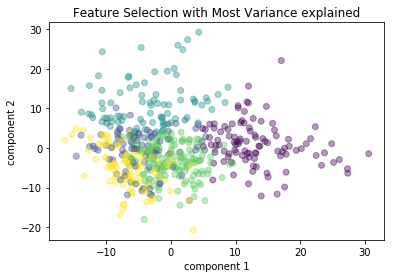

In [726]:
X = qualified_player_avgs[all_cols]
pca = PCA(n_components=10)
pca.fit(X)

X_pca = pca.transform(X)
df = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_),columns=['Cumulative Variance Explained'])
df.index_name="N principle Components"
print(df)

kmeans = KMeans(n_clusters=5)
kmeans.fit(X_pca)

y_kmeans = kmeans.predict(X_pca)
plt.scatter(X_pca[:,0],X_pca[:,1],alpha=0.4,c=y_kmeans,cmap='viridis')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('Feature Selection with Most Variance explained');


x = pd.DataFrame(columns=range_n_clusters,index=range(0,max(range_n_clusters)))

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters,n_init=50,max_iter=1000)
    y_kmeans = kmeans.fit_predict(X)
    silhouette_score_mean = silhouette_score(X,y_kmeans)
    
    x[n_clusters]=pd.Series(y_kmeans).value_counts().sort_index()
    print("Average silhouette with {0:2} clusters = {1:3}".format(n_clusters,silhouette_score_mean) )
x

   Cumulative Variance Explained
0                       0.890330
1                       0.980443
2                       0.988726
Average silhouette with  6 clusters = 0.31748984544772335
Average silhouette with  7 clusters = 0.29989649334899887
Average silhouette with  8 clusters = 0.3060835047476304
Average silhouette with  9 clusters = 0.29663010273035173
Average silhouette with 10 clusters = 0.2961789466796713


,6,7,8,9,10
0,41.0,66.0,45.0,57.0,88
1,130.0,100.0,120.0,54.0,33
2,100.0,64.0,72.0,24.0,81
3,71.0,43.0,16.0,97.0,42
4,119.0,104.0,70.0,90.0,54
5,59.0,26.0,108.0,16.0,11
6,NaN,117.0,24.0,43.0,15
7,NaN,NaN,65.0,54.0,51
8,NaN,NaN,NaN,85.0,87
9,NaN,NaN,NaN,NaN,58


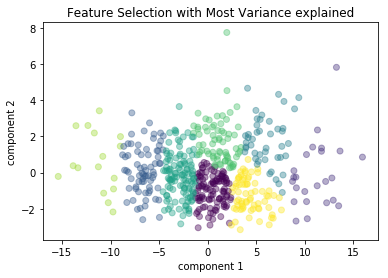

In [727]:
fewer_cols = scoringVars+defensiveVars+per100pVars_other
X = qualified_player_avgs[fewer_cols]
pca = PCA(n_components=3)
pca.fit(X)

X_pca = pca.transform(X)
df = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_),columns=['Cumulative Variance Explained'])
df.index_name="N principle Components"
print(df)

kmeans = KMeans(n_clusters=8)
kmeans.fit(X_pca)

y_kmeans = kmeans.predict(X_pca)
plt.scatter(X_pca[:,0],X_pca[:,1],alpha=0.4,c=y_kmeans,cmap='viridis')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('Feature Selection with Most Variance explained');
range_n_clusters = [6,7,8,9,10]

x = pd.DataFrame(columns=range_n_clusters,index=range(0,max(range_n_clusters)))
for n_clusters in range_n_clusters:
    
    kmeans = KMeans(n_clusters=n_clusters,n_init=50,max_iter=1000)
    y_kmeans = kmeans.fit_predict(X)
    silhouette_score_mean = silhouette_score(X,y_kmeans)
    
    x[n_clusters]=pd.Series(y_kmeans).value_counts().sort_index()
    print("Average silhouette with {0:2} clusters = {1:3}".format(n_clusters,silhouette_score_mean) )
x

   Cumulative Variance Explained
0                       0.499161
1                       0.806345
2                       0.893100
3                       0.943812
4                       0.976132
Average silhouette with  6 clusters = 0.20154523342771635
Average silhouette with  7 clusters = 0.18372648834761726
Average silhouette with  8 clusters = 0.17546935781766465
Average silhouette with  9 clusters = 0.17962523821035833
Average silhouette with 10 clusters = 0.1761064647142145


,6,7,8,9,10
0,103.0,60.0,83.0,55.0,58
1,91.0,137.0,65.0,43.0,49
2,48.0,75.0,109.0,60.0,87
3,72.0,57.0,31.0,33.0,65
4,153.0,48.0,87.0,92.0,24
5,53.0,32.0,63.0,31.0,26
6,NaN,111.0,36.0,104.0,31
7,NaN,NaN,46.0,54.0,88
8,NaN,NaN,NaN,48.0,42
9,NaN,NaN,NaN,NaN,50


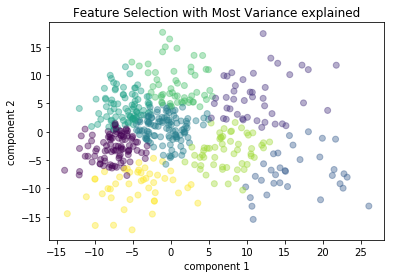

In [742]:
fewer_cols = scoringVars+defensiveVars+advancedVars+per100pVars_other
X = qualified_player_avgs[fewer_cols]
pca = PCA(n_components=5)
pca.fit(X)

X_pca = pca.transform(X)
df = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_),columns=['Cumulative Variance Explained'])
df.index_name="N principle Components"
print(df)

kmeans = KMeans(n_clusters=8)
kmeans.fit(X_pca)

y_kmeans = kmeans.predict(X_pca)
plt.scatter(X_pca[:,0],X_pca[:,1],alpha=0.4,c=y_kmeans,cmap='viridis')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('Feature Selection with Most Variance explained');
range_n_clusters = [6,7,8,9,10]

x = pd.DataFrame(columns=range_n_clusters,index=range(0,max(range_n_clusters)))
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters,n_init=50,max_iter=1000)
    y_kmeans = kmeans.fit_predict(X)
    silhouette_score_mean = silhouette_score(X,y_kmeans)
    y_kmeans
    x[n_clusters]=pd.Series(y_kmeans).value_counts().sort_index()
    print("Average silhouette with {0:2} clusters = {1:3}".format(n_clusters,silhouette_score_mean))
x

This one I like a lot, check silhouette scores

We pick 8 with that as our final choice and move on to giving them labels and associated analysis

In [744]:
fewer_cols = scoringVars+defensiveVars+advancedVars+per100pVars_other
X = qualified_player_avgs[fewer_cols]
pca = PCA(n_components=5)
pca.fit(X)

X_pca = pca.transform(X)

kmeans = KMeans(n_clusters=8,n_init=100,max_iter=1000)

kmeans.fit(X_pca)

y_kmeans = kmeans.predict(X_pca)
len(y_kmeans)

520

In [747]:
qualified_player_avgs['NEW_POSITION']=y_kmeans

In [753]:
player_name_dict = qualified_df.reset_index()[['PLAYER_ID','PLAYER_NAME']].set_index('PLAYER_ID').drop_duplicates()

In [779]:
player_id = qualified_player_avgs.reset_index().PLAYER_ID
qualified_player_avgs['PLAYER_NAME'] = player_name_dict.loc[player_id,:]


In [776]:
qualified_player_avgs[['PLAYER_NAME','NEW_POSITION']][qualified_player_avgs['NEW_POSITION']==1]

,PLAYER_NAME,NEW_POSITION
PLAYER_ID,,
101128,Francisco Garcia,1
101150,Lou Williams,1
101187,Alan Anderson,1
1626159,Justise Winslow,1
1626163,Frank Kaminsky,1
1626169,Stanley Johnson,1
1626179,Terry Rozier,1
1626181,Norman Powell,1
1626195,Willy Hernangomez,1


This does not pass the eye test at all

its actually perplexing how poorly this did. Lets do some quick searching to see if data works

In [1231]:
print(all_cols)

custom_cols = ['AST_PCT','AST_RATIO','DREB_PCT','EFG_PCT','OREB_PCT',
               'TS_PCT','USG_PCT','FG3A','FG3_PCT','FTA','PCT_AST_2PM',
               'PCT_AST_3PM','PCT_PTS_2PT_MR','PCT_PTS_FT','PCT_PTS_OFF_TOV',
               'PCT_PTS_PAINT','PCT_UAST_FGM','DEF_PCT_PLUSMINUS_2Pt',
               'DEF_PCT_PLUSMINUS_3Pt','DEF_PCT_PLUSMINUS_Lt6','AST','STL',
               'PF','TOV'
              ]
scoringVars

['AST_PCT', 'AST_RATIO', 'AST_TO', 'DEF_RATING', 'DREB_PCT', 'EFG_PCT', 'OFF_RATING', 'OREB_PCT', 'PACE', 'REB_PCT', 'TM_TOV_PCT', 'TS_PCT', 'USG_PCT', 'FG3A', 'FG3M', 'FG3_PCT', 'FGA', 'FGM', 'FG_PCT', 'FTA', 'FTM', 'FT_PCT', 'PCT_AST_2PM', 'PCT_AST_3PM', 'PCT_AST_FGM', 'PCT_FGA_2PT', 'PCT_FGA_3PT', 'PCT_PTS_2PT', 'PCT_PTS_2PT_MR', 'PCT_PTS_3PT', 'PCT_PTS_FB', 'PCT_PTS_FT', 'PCT_PTS_OFF_TOV', 'PCT_PTS_PAINT', 'PCT_UAST_2PM', 'PCT_UAST_3PM', 'PCT_UAST_FGM', 'DEF_FREQ_2Pt', 'DEF_FREQ_3Pt', 'DEF_FREQ_Gt15', 'DEF_FREQ_Lt10', 'DEF_FREQ_Lt6', 'DEF_PCT_PLUSMINUS_2Pt', 'DEF_PCT_PLUSMINUS_3Pt', 'DEF_PCT_PLUSMINUS_Gt15', 'DEF_PCT_PLUSMINUS_Lt10', 'DEF_PCT_PLUSMINUS_Lt6', 'AST', 'BLK', 'DREB', 'OREB', 'STL', 'PTS', 'PF', 'TOV', 'BLKA', 'PFD', 'PLUS_MINUS']


['PCT_AST_2PM',
 'PCT_AST_3PM',
 'PCT_AST_FGM',
 'PCT_FGA_2PT',
 'PCT_FGA_3PT',
 'PCT_PTS_2PT',
 'PCT_PTS_2PT_MR',
 'PCT_PTS_3PT',
 'PCT_PTS_FB',
 'PCT_PTS_FT',
 'PCT_PTS_OFF_TOV',
 'PCT_PTS_PAINT',
 'PCT_UAST_2PM',
 'PCT_UAST_3PM',
 'PCT_UAST_FGM']

In [1251]:
fewer_cols = scoringVars + defensiveVars[4:] + ['AST','TS_PCT','FTA','AST_RATIO','AST_PCT',
                                                'OREB_PCT','TS_PCT'
                                               ]

X = qualified_player_avgs[fewer_cols]
X = scale(X)
pca = PCA(n_components=2)
pca.fit(X)

X = pca.transform(X)
df = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_),columns=['Cumulative Variance Explained'])
df.index_name="N principle Components"

kmeans = KMeans(n_clusters=7,n_init=50,max_iter=500)
kmeans.fit(X)

y_kmeans = kmeans.predict(X)
qualified_player_avgs['NEW_POSITION']=y_kmeans
player_id = qualified_player_avgs.reset_index().PLAYER_ID
qualified_player_avgs['PLAYER_NAME'] = player_name_dict.loc[player_id,:]
qualified_player_avgs
silhouette_score(X,y_kmeans)

0.4131837052673271

In [1318]:
for i in range(0,8):
    x = qualified_player_avgs[['PLAYER_NAME','NEW_POSITION','MIN']]\
    [qualified_player_avgs['NEW_POSITION']==i]
    print(list(x.sort_values('MIN',ascending=False).PLAYER_NAME.head(10)))
    print("\n")

['Jimmy Butler', 'Andrew Wiggins', 'Paul George', 'DeMar DeRozan', 'Gordon Hayward', 'Carmelo Anthony', 'Kevin Durant', 'Blake Griffin', 'Ben Simmons', 'Victor Oladipo']


['Trevor Ariza', 'Klay Thompson', 'Robert Covington', 'DeMarre Carroll', 'JJ Redick', 'James Anderson', 'Kyle Korver', 'Otto Porter Jr.', 'Ryan Anderson', 'Allen Crabbe']


['Anthony Davis', 'Karl-Anthony Towns', 'DeMarcus Cousins', 'Marc Gasol', 'LaMarcus Aldridge', 'DeAndre Jordan', 'Andre Drummond', 'Dwight Howard', 'Nikola Vucevic', 'Rudy Gobert']


['Lonzo Ball', 'Stephen Curry', 'George Hill', 'Darren Collison', 'Zach LaVine', 'Joe Johnson', 'Dion Waiters', 'Seth Curry', 'Kendall Marshall', 'Marcus Smart']


['Chris Bosh', 'Jabari Parker', 'Paul Millsap', 'Tobias Harris', 'Thaddeus Young', 'Kevin Love', 'Al Horford', 'Luol Deng', 'Harrison Barnes', 'Wilson Chandler']


['James Harden', 'LeBron James', 'Damian Lillard', 'John Wall', 'Kyle Lowry', 'Kemba Walker', 'Russell Westbrook', 'Kyrie Irving', 'Goran Dragic

This is as good as I'm going to get and really need to move on now.


In [1319]:
new_position_dict = {0:'All Star Wing',
                     1:'3-and-D',
                     2:'Traditional Center',
                     3:'Point Guard',
                     4:'Stretch 4',
                     5:'Offensive Guard',
                     6:'Scoring wing'
                    }

In [1254]:
pickle.dump(qualified_player_avgs,open('PlayersClassified.pkl','wb'))

Ignoring any pursuit of a great score we end up with a pretty good classification actually

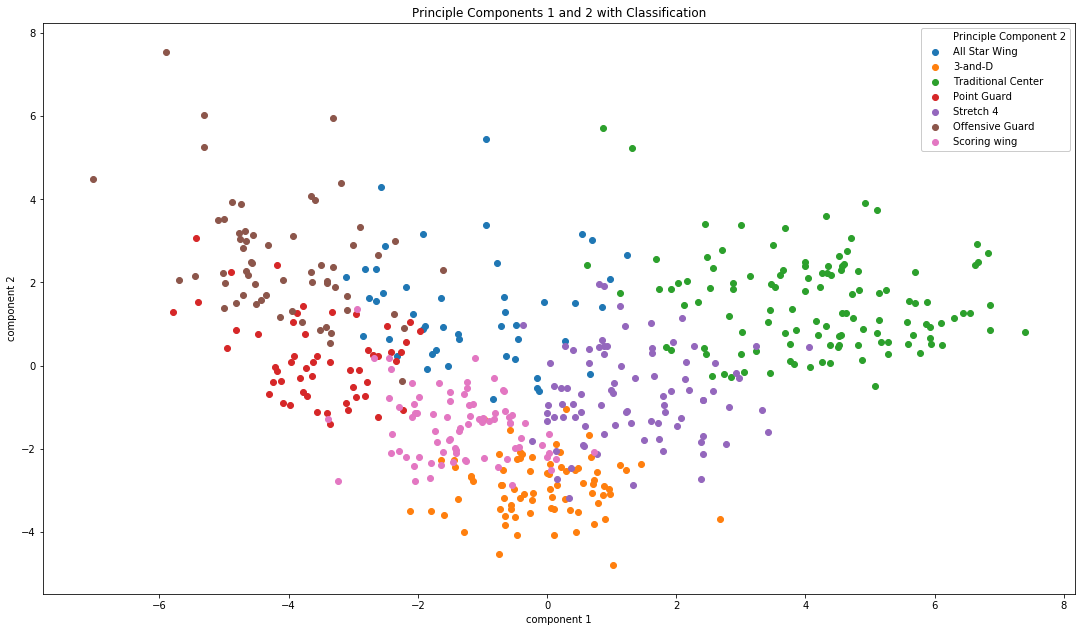

In [1370]:

PCA_df_label = pd.DataFrame(X_pca,columns=['Principle Component 1','Principle Component 2'])
PCA_df_label['PLAYER_NAME']=pd.Series(qualified_player_avgs.PLAYER_NAME)
PCA_df_label['POSITION']=pd.Series(y_kmeans).map(new_position_dict)
#PCA_df_label.head()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5);

plt.scatter(PCA_df_label.iloc[:,0],PCA_df_label.iloc[:,1],alpha=0,c=y_kmeans,cmap='viridis')

for i in range(0,7):
    PC1 = PCA_df_label.loc[pd.Series(y_kmeans==i),:].iloc[:,0]
    PC2 = PCA_df_label.loc[pd.Series(y_kmeans==i),:].iloc[:,1]
    plt.scatter(PC1,PC2,label=list(new_position_dict.values())[i])
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('Principle Components 1 and 2 with Classification');
plt.legend(framealpha=1,frameon=True)


In [1146]:
qualified_player_avgs['NEW_POSITION']=new_position
qualified_player_avgs['NEW_POSITION_NAMED']=\
qualified_player_avgs['NEW_POSITION'].map(new_position_dict)

PLAYER_ID
101106            Defensive Big
101107                  3-and-D
101108     Offensive Super-Star
101109              Point Guard
101110                  3-and-D
101112                  3-and-D
101114              Point Guard
101122                  3-and-D
101123                  3-and-D
101126     Offensive Super-Star
101127              Point Guard
101128                  3-and-D
101131        Defensive Forward
101133        Defensive Forward
101135        Defensive Forward
101138        Defensive Forward
101139                  3-and-D
101141                Stretch 4
101145     Offensive Super-Star
101150     Offensive Super-Star
101154            Defensive Big
101161            Defensive Big
101162            Defensive Big
101179              Point Guard
101181              Point Guard
101187                  3-and-D
101198     Offensive Super-Star
1495          Defensive Forward
1626143       Defensive Forward
1626144    Offensive Super-Star
                   ...        

In [1261]:
y_full = qualified_player_avgs.NEW_POSITION

Now we move onto a sort of predicting

In [1266]:
from sklearn.tree import DecisionTreeClassifier
y_full_list = pd.Series(y_full.index)
college_draft_prospects = pickle.load(open('FullProspectData.pkl','rb'))

In [1273]:
college_full_list = pd.Series(college_draft_prospects.index)
y = y_full[college_full_list]

In [1276]:
y = y.dropna()

In [1304]:
X = college_draft_prospects.loc[pd.Series(y.index),:]
X = X.drop(['POSITION','PLAYER_NAME_y','School','PLAYER_NAME_x'],axis=1)
X = pd.get_dummies(X)
X.count()
from sklearn.preprocessing import Imputer
imp = Imputer(strategy='mean')
X = imp.fit_transform(X)
X

array([[ 9.8  ,  0.664, 14.7  , ...,  0.   ,  0.   ,  0.   ],
       [ 2.7  ,  0.44 ,  6.1  , ...,  0.   ,  1.   ,  0.   ],
       [ 3.2  ,  0.481,  6.7  , ...,  0.   ,  0.   ,  1.   ],
       ...,
       [ 7.4  ,  0.504, 14.6  , ...,  1.   ,  0.   ,  0.   ],
       [ 6.6  ,  0.639, 10.3  , ...,  0.   ,  0.   ,  0.   ],
       [ 3.9  ,  0.492,  7.9  , ...,  0.   ,  1.   ,  0.   ]])

In [1371]:
from sklearn.cross_validation import train_test_split
# split the data with 50% in each set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,
                                  train_size=0.7)

In [1391]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=500, random_state=0,max_features=10,
                               min_samples_split=5)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [1392]:
from sklearn import metrics
print(metrics.classification_report(y_pred, y_test))

             precision    recall  f1-score   support

        0.0       0.17      0.33      0.22         3
        1.0       0.20      0.33      0.25         6
        2.0       0.62      0.91      0.74        11
        3.0       0.57      0.33      0.42        12
        4.0       0.90      0.36      0.51        25
        5.0       0.36      0.80      0.50         5
        6.0       0.33      0.40      0.36        10

avg / total       0.60      0.47      0.48        72



Random Forest works decently.

In [1394]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(metrics.classification_report(y_pred, y_test))

             precision    recall  f1-score   support

        0.0       0.33      0.14      0.20        14
        1.0       0.40      0.36      0.38        11
        2.0       0.50      0.57      0.53        14
        3.0       0.71      0.38      0.50        13
        4.0       0.40      0.40      0.40        10
        5.0       0.45      0.83      0.59         6
        6.0       0.08      0.25      0.12         4

avg / total       0.45      0.40      0.40        72



In [1396]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
model = make_pipeline(Lasso(alpha=0.001),LogisticRegression)
model.fit(X_train,y_train)

TypeError: All intermediate steps should be transformers and implement fit and transform. 'Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)' (type <class 'sklearn.linear_model.coordinate_descent.Lasso'>) doesn't

Lets take a look at the upcoming draft prospects

In [1413]:
combine_columns = ['PLAYER_NAME','DRAFT_YEAR','POSITION','STANDING_VERTICAL_LEAP',
                   'MAX_VERTICAL_LEAP','LANE_AGILITY_TIME',
                   'MODIFIED_LANE_AGILITY_TIME','THREE_QUARTER_SPRINT',
                   'BENCH_PRESS','HEIGHT_WO_SHOES','WEIGHT','WINGSPAN',
                   'STANDING_REACH','BODY_FAT_PCT','HAND_LENGTH','HAND_WIDTH'                  
                  ]
params = {'LeagueID':'00'}
full_combine_df = pd.DataFrame(columns = combine_columns)
for i in range(18,20):
    year="20"+format(i,'02d')+"-"+format(i+1,'02d')
    params.update({"SeasonYear":year})
    df1 = get_nba_data(endpt="draftcombinedrillresults",params=params)
    df2 = get_nba_data(endpt="draftcombineplayeranthro",params=params)
    dfMerged = pd.merge(df1,df2)
#    dfMerged['PLAYER_ID']=pd.Series(dfMerged.PLAYER_ID,dtype=str)
    if(i>13):
        dfMerged['PLAYER_NAME'] = dfMerged['PLAYER_NAME']
#        dfMerged['PLAYER_ID']=(dfMerged['PLAYER_NAME']+"("+year[0:4]+")").map(Player_ID_Dict)
#        dfMerged['PLAYER_ID']=pd.Series(dfMerged['PLAYER_ID'],dtype=str).str.split(".").str.get(0)

    dfMerged['DRAFT_YEAR'] = int(year[0:4])    
#    dfMerged = dfMerged[dfMerged['PLAYER_ID']!='nan']

#    dfMerged = dfMerged.set_index('PLAYER_ID')[combine_columns]
        
    full_combine_df = pd.concat([full_combine_df,dfMerged])
full_combine_df.fillna(value=np.nan, inplace=True)
full_combine_df = full_combine_df.drop(['MODIFIED_LANE_AGILITY_TIME','BENCH_PRESS'],axis=1)
combine_2018 = full_combine_df

In [1421]:
combine_2018['PLAYER_NAME'] = combine_2018['PLAYER_NAME'] + "(" +\
            pd.Series(combine_2018.DRAFT_YEAR,dtype=str).str[:4] + ")"
combine_2018 = combine_2018.set_index('TEMP_PLAYER_ID')
college_stats_df=sportsRefCBBTableMaker(combine_2018,
                                        ['all_players_per_min','all_players_advanced'])

In [1422]:
college_stats_df

,PLAYER_ID,PLAYER_NAME,CONF,School,G,GS,MP,FG,FGA,FG%,...,BLK%,TOV%,USG%,OWS,DWS,WS,WS/40,OBPM,DBPM,BPM
